### Benchmark Calibration

    Noise Level                          Method  Mean Calibration Error  \
0          0.05                Vanilla Isotonic                0.665282   
1          0.05        Nearly Isotonic (Strict)                0.022164   
2          0.05       Nearly Isotonic (Relaxed)                0.020779   
3          0.05   Nearly Isotonic Path (Strict)                0.033576   
4          0.05  Nearly Isotonic Path (Relaxed)                0.038309   
5          0.05                  I-Spline Calib                0.004795   
6          0.05                Relax PAVA (10%)                0.018477   
7          0.10                Vanilla Isotonic                0.666612   
8          0.10        Nearly Isotonic (Strict)                0.030014   
9          0.10       Nearly Isotonic (Relaxed)                0.059251   
10         0.10   Nearly Isotonic Path (Strict)                0.076402   
11         0.10  Nearly Isotonic Path (Relaxed)                0.079183   
12         0.10          

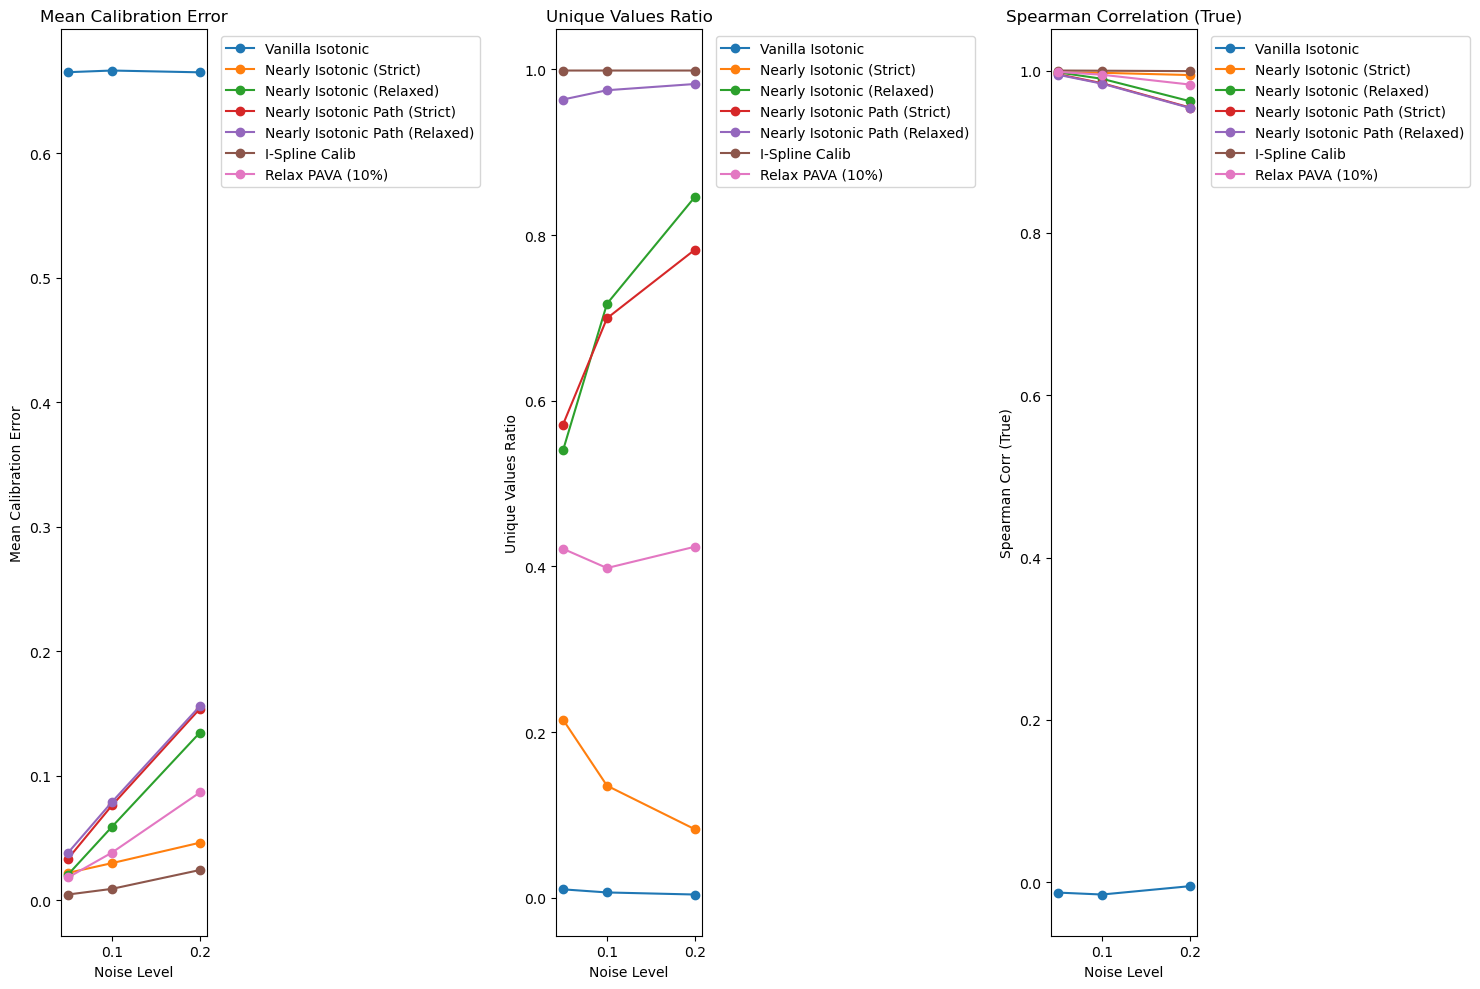

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

# Import calibration methods
from calibre import (
    nearly_isotonic_opt, 
    nearly_isotonic_path, 
    ispline_calib, 
    relax_pava,
    mean_calibration_error,
    binned_calibration_error,
    correlation_metrics,
    unique_value_counts
)

def generate_nonlinear_data(n_samples=1000, noise_level=0.1):
    """
    Generate synthetic data with non-linear true function and added noise.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    noise_level : float
        Standard deviation of the added Gaussian noise
    
    Returns:
    --------
    x : array
        Input features
    y_true : array
        True underlying function values
    y_noisy : array
        Noisy predictions
    """
    # Generate x values
    x = np.linspace(0, 1, n_samples)
    
    # Non-linear true function (e.g., a combination of sine and exponential)
    y_true = np.sin(2 * np.pi * x) * np.exp(x - 0.5)
    
    # Add Gaussian noise
    y_noisy = y_true + np.random.normal(0, noise_level, size=n_samples)
    
    return x, y_true, y_noisy

def benchmark_calibration_methods(noise_levels=[0.05, 0.1, 0.2]):
    """
    Benchmark different calibration methods across various noise levels.
    
    Parameters:
    -----------
    noise_levels : list
        Different noise levels to test
    
    Returns:
    --------
    results_df : pandas.DataFrame
        Comprehensive results of calibration methods
    """
    # Initialize results storage
    results = []
    
    # Iterate through different noise levels
    for noise in noise_levels:
        # Generate data
        x, y_true, y_noisy = generate_nonlinear_data(noise_level=noise)
        
        # Split data
        x_train, x_test, y_train, y_test, y_true_train, y_true_test = train_test_split(
            x, y_noisy, y_true, test_size=0.2, random_state=42
        )
        
        # Calibration methods to test
        calibration_methods = [
            ('Vanilla Isotonic', lambda x, y: IsotonicRegression(out_of_bounds='clip').fit_transform(x, y)),
            ('Nearly Isotonic (Strict)', lambda x, y: nearly_isotonic_opt(x, y, lam=10.0)),
            ('Nearly Isotonic (Relaxed)', lambda x, y: nearly_isotonic_opt(x, y, lam=0.1)),
            ('Nearly Isotonic Path (Strict)', lambda x, y: nearly_isotonic_path(x, y, lam=10.0)),
            ('Nearly Isotonic Path (Relaxed)', lambda x, y: nearly_isotonic_path(x, y, lam=0.1)),
            ('I-Spline Calib', lambda x, y: ispline_calib(x, y)),
            ('Relax PAVA (10%)', lambda x, y: relax_pava(x, y, percentile=10)),
        ]
        
        # Compute metrics for each method
        for method_name, calib_func in calibration_methods:
            # Apply calibration
            y_calibrated = calib_func(x_train, y_train)
            
            # Evaluate metrics
            mce = mean_calibration_error(y_true_train, y_calibrated)
            bce = binned_calibration_error(y_true_train, y_calibrated, n_bins=10)
            corr = correlation_metrics(y_true_train, y_calibrated, x=x_train, y_orig=y_train)
            unique_counts = unique_value_counts(y_calibrated, y_orig=y_train)
            
            # Store results
            results.append({
                'Noise Level': noise,
                'Method': method_name,
                'Mean Calibration Error': mce,
                'Binned Calibration Error': bce,
                'Spearman Corr (True)': corr['spearman_corr_to_y_true'],
                'Spearman Corr (Orig)': corr.get('spearman_corr_to_y_orig', np.nan),
                'Unique Values Ratio': unique_counts['unique_value_ratio'],
                'N Unique Values': unique_counts['n_unique_y_pred'],
                'N Unique Values (Orig)': unique_counts['n_unique_y_orig']
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run benchmark
benchmark_results = benchmark_calibration_methods()

# Display results
print(benchmark_results)

# Optional: Visualization of results
plt.figure(figsize=(15, 10))

# Metrics to plot
metrics_to_plot = [
    ('Mean Calibration Error', 'Mean Calibration Error'),
    ('Unique Values Ratio', 'Unique Values Ratio'),
    ('Spearman Corr (True)', 'Spearman Correlation (True)')
]

# Create subplots for each metric
for i, (col_name, title) in enumerate(metrics_to_plot, 1):
    plt.subplot(1, 3, i)
    for method in benchmark_results['Method'].unique():
        subset = benchmark_results[benchmark_results['Method'] == method]
        plt.plot(subset['Noise Level'], subset[col_name], 
                 marker='o', label=method)
    plt.title(title)
    plt.xlabel('Noise Level')
    plt.ylabel(col_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

    Noise Level                          Method  Mean Calibration Error  \
0          0.05                Vanilla Isotonic                0.805213   
1          0.05        Nearly Isotonic (Strict)                0.026730   
2          0.05       Nearly Isotonic (Relaxed)                0.025160   
3          0.05   Nearly Isotonic Path (Strict)                0.036943   
4          0.05  Nearly Isotonic Path (Relaxed)                0.040358   
5          0.05                  I-Spline Calib                0.008261   
6          0.05                Relax PAVA (10%)                0.231667   
7          0.10                Vanilla Isotonic                0.806695   
8          0.10        Nearly Isotonic (Strict)                0.034507   
9          0.10       Nearly Isotonic (Relaxed)                0.060570   
10         0.10   Nearly Isotonic Path (Strict)                0.077870   
11         0.10  Nearly Isotonic Path (Relaxed)                0.080706   
12         0.10          

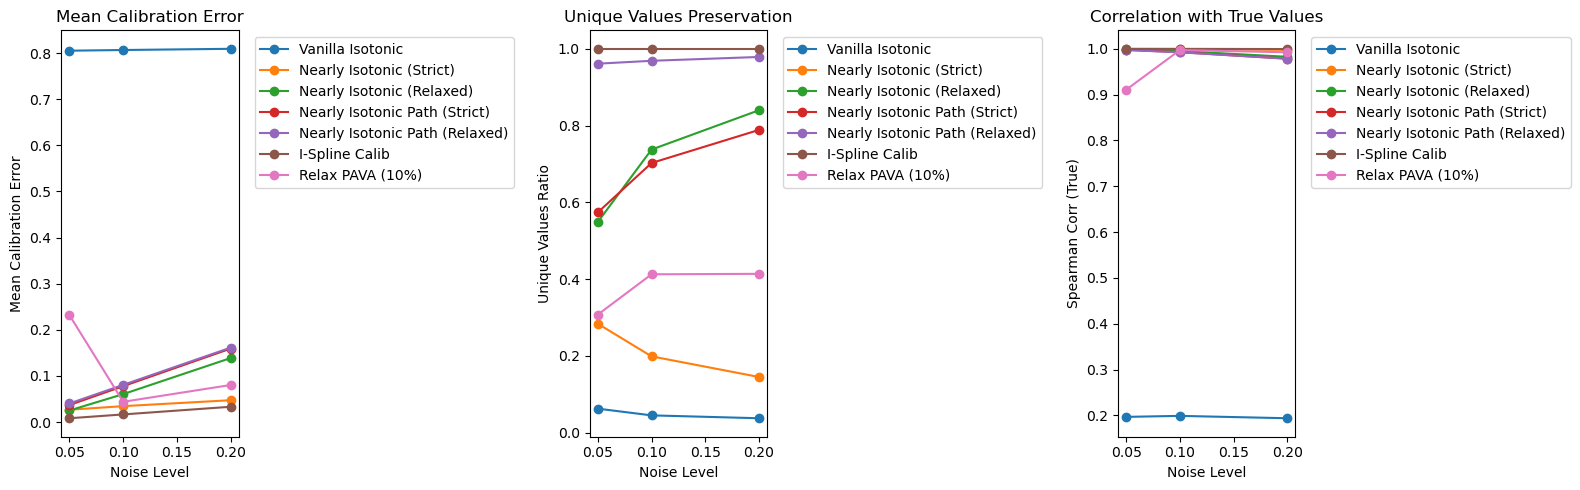

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler

# Import calibration methods
from calibre import (
    nearly_isotonic_opt, 
    nearly_isotonic_path, 
    ispline_calib, 
    relax_pava,
    mean_calibration_error,
    binned_calibration_error,
    correlation_metrics,
    unique_value_counts
)

def generate_continuous_data(n_samples=1000, noise_level=0.1):
    """
    Generate synthetic continuous data with non-linear true function and added noise.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    noise_level : float
        Standard deviation of the added Gaussian noise
    
    Returns:
    --------
    x : array
        Input features
    y_true : array
        True underlying function values
    y_noisy : array
        Noisy predictions
    """
    # Multiple non-linear functions to create complexity
    np.random.seed(42)
    
    # Generate x values with more complex distribution
    x = np.random.uniform(0, 1, n_samples)
    
    # Combine multiple non-linear transformations
    y_true = (
        np.sin(2 * np.pi * x) * np.exp(x - 0.5) +  # Sine with exponential
        0.5 * x**2 +  # Quadratic component
        0.3 * np.log(x + 0.1)  # Logarithmic component
    )
    
    # Standardize to control overall scale
    scaler = StandardScaler()
    y_true = scaler.fit_transform(y_true.reshape(-1, 1)).ravel()
    
    # Add Gaussian noise
    y_noisy = y_true + np.random.normal(0, noise_level, size=n_samples)
    
    return x, y_true, y_noisy

def benchmark_calibration_methods(noise_levels=[0.05, 0.1, 0.2]):
    """
    Benchmark different calibration methods across various noise levels.
    
    Parameters:
    -----------
    noise_levels : list
        Different noise levels to test
    
    Returns:
    --------
    results_df : pandas.DataFrame
        Comprehensive results of calibration methods
    """
    # Initialize results storage
    results = []
    
    # Iterate through different noise levels
    for noise in noise_levels:
        # Generate data
        x, y_true, y_noisy = generate_continuous_data(noise_level=noise)
        
        # Split data
        x_train, x_test, y_train, y_test, y_true_train, y_true_test = train_test_split(
            x, y_noisy, y_true, test_size=0.2, random_state=42
        )
        
        # Calibration methods to test
        calibration_methods = [
            ('Vanilla Isotonic', lambda x, y: IsotonicRegression(out_of_bounds='clip').fit_transform(x, y)),
            ('Nearly Isotonic (Strict)', lambda x, y: nearly_isotonic_opt(x, y, lam=10.0)),
            ('Nearly Isotonic (Relaxed)', lambda x, y: nearly_isotonic_opt(x, y, lam=0.1)),
            ('Nearly Isotonic Path (Strict)', lambda x, y: nearly_isotonic_path(x, y, lam=10.0)),
            ('Nearly Isotonic Path (Relaxed)', lambda x, y: nearly_isotonic_path(x, y, lam=0.1)),
            ('I-Spline Calib', lambda x, y: ispline_calib(x, y)),
            ('Relax PAVA (10%)', lambda x, y: relax_pava(x, y, percentile=10)),
        ]
        
        # Compute metrics for each method
        for method_name, calib_func in calibration_methods:
            # Apply calibration
            y_calibrated = calib_func(x_train, y_train)
            
            # Evaluate metrics
            mce = mean_calibration_error(y_true_train, y_calibrated)
            bce = binned_calibration_error(y_true_train, y_calibrated, n_bins=10)
            corr = correlation_metrics(y_true_train, y_calibrated, x=x_train, y_orig=y_train)
            unique_counts = unique_value_counts(y_calibrated, y_orig=y_train)
            
            # Store results
            results.append({
                'Noise Level': noise,
                'Method': method_name,
                'Mean Calibration Error': mce,
                'Binned Calibration Error': bce,
                'Spearman Corr (True)': corr['spearman_corr_to_y_true'],
                'Spearman Corr (Orig)': corr.get('spearman_corr_to_y_orig', np.nan),
                'Unique Values Ratio': unique_counts['unique_value_ratio'],
                'N Unique Values': unique_counts['n_unique_y_pred'],
                'N Unique Values (Orig)': unique_counts['n_unique_y_orig']
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run benchmark
benchmark_results = benchmark_calibration_methods()

# Display results
print(benchmark_results)

# Visualization
plt.figure(figsize=(16, 5))

# Metrics to plot
metrics_to_plot = [
    ('Mean Calibration Error', 'Mean Calibration Error'),
    ('Unique Values Ratio', 'Unique Values Preservation'),
    ('Spearman Corr (True)', 'Correlation with True Values')
]

# Create subplots for each metric
for i, (col_name, title) in enumerate(metrics_to_plot, 1):
    plt.subplot(1, 3, i)
    for method in benchmark_results['Method'].unique():
        subset = benchmark_results[benchmark_results['Method'] == method]
        plt.plot(subset['Noise Level'], subset[col_name], 
                 marker='o', label=method)
    plt.title(title)
    plt.xlabel('Noise Level')
    plt.ylabel(col_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()